In [7]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [8]:
# Make sure to have the latest version of packages. In order to use latest environment, 
# choose "Always use latest environment" option in Notebook options

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq duckduckgo_search
    !pip install -Uqq fastai
    
# make sure you have python 3.10 and duckduckgo 3.9.5
import sys
print(sys.version)

import duckduckgo_search
print(duckduckgo_search.__version__)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
6.1.7


In [9]:
from itertools import islice
from duckduckgo_search import DDGS
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # DDGS().images return an interator containing all images found
    # we use islice to limit the number of results returned
    return L(islice(DDGS().images(term), max_images)).itemgot('image')

In [10]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('clown fish photos', max_images=1)
urls[0]

Searching for 'clown fish photos'


'https://www.thesprucepets.com/thmb/nQ05m22d4IVNLXmzWSwod31aSbI=/3604x2403/filters:no_upscale():max_bytes(150000):strip_icc()/close-up-of-clown-fish-swimming-by-coral-1145795316-07b78e286f674781a83abbcada6f38c8.jpg'

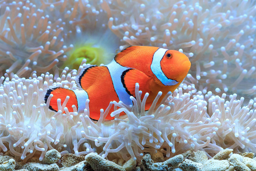

In [11]:
from fastdownload import download_url
dest = 'clown fish.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'coral reef photos'


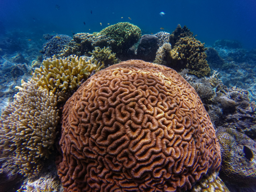

In [12]:
download_url(search_images('coral reef photos', max_images=1)[0], 'coral reef.jpg', show_progress=True)
Image.open('coral reef.jpg').to_thumb(256,256)

In [13]:
searches = 'coral reef','clown fish'
path = Path('clown_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sunlight photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} group photo'))
    sleep(10)

Searching for 'coral reef photo'
Searching for 'coral reef sunlight photo'
Searching for 'coral reef group photo'
Searching for 'clown fish photo'
Searching for 'clown fish sunlight photo'
Searching for 'clown fish group photo'


In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

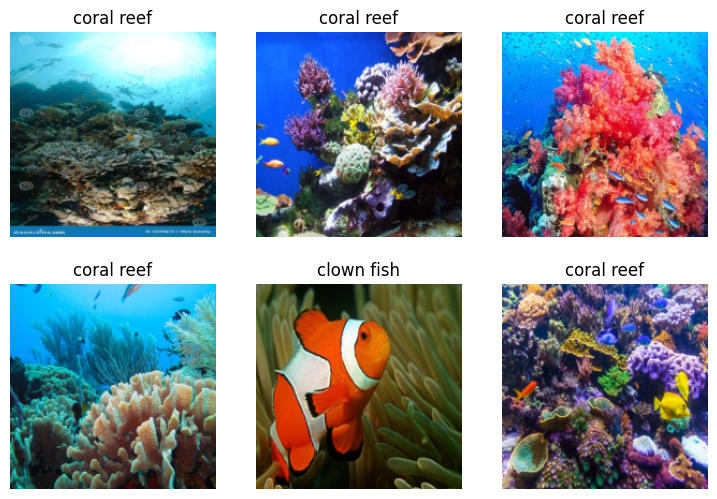

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.812546,1.279834,0.290323,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.324783,0.167199,0.096774,00:27
1,0.179433,0.036623,0.000000,00:28
2,0.121255,0.031065,0.000000,00:29


In [18]:
is_clownfish,_,probs = learn.predict(PILImage.create('clown fish.jpg'))
print(f"This is a: {is_clownfish}.")
print(f"Probability it's a clown fish: {probs[0]:.4f}")

This is a: clown fish.
Probability it's a clown fish: 1.0000
